In [ ]:
#tải thư viện
!pip install tensorflow

Import các thư viện cần thiết:

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from matplotlib import pyplot as plt


Mount tới Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Khai báo khởi tạo mảng chứa dữ liệu:

In [3]:
data = []
img_size = (200, 200)
number_class = 2
class_names = ["không hỏa hoạn", "hỏa hoạn"]

Liên kết tới thư mục chứa dữ liệu

In [4]:
# Truy cập tệp dữ liệu
data_folder = "/content/drive/MyDrive/AI/data"


Load dữ liệu hình ảnh và video:

In [5]:
for folder in os.listdir(data_folder):
    current_path = os.path.join(data_folder, folder)
    for file in os.listdir(current_path):
        current_file = os.path.join(current_path, file)
        if file.endswith(".jpg") or file.endswith(".png"):
            img = cv2.imread(current_file, cv2.IMREAD_GRAYSCALE)
            img = img / 255.0
            img = cv2.resize(img, img_size)
            if folder == "KhongHoaHoan":
                data.append([img, 0])
            else:
                data.append([img, 1])
        elif file.endswith(".mp4"):
            # Xử lý video (đọc và chia thành các khung hình)
            cap = cv2.VideoCapture(current_file)
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                img = cv2.resize(img, img_size)
                if folder == "KhongHoaHoan":
                    data.append([img, 0])
                else:
                    data.append([img, 1])
            cap.release()

Trộn ngẫu nhiên dữ liệu

In [6]:
# Ramdom dữ liệu
import random
random.shuffle(data)

In [7]:
X = []
Y = []

for x, y in data:
    X.append(x)
    Y.append(y)


Reshape và chuẩn bị dữ liệu cho việc huấn luyện mô hình:

In [8]:
X = np.array(X)
X.reshape(-1, img_size[0], img_size[1], 1)

array([[[[0.58514706],
         [0.56711213],
         [0.59191176],
         ...,
         [0.64705882],
         [0.64705882],
         [0.63921569]],

        [[0.62441176],
         [0.57602941],
         [0.56887255],
         ...,
         [0.64747243],
         [0.64705882],
         [0.64249142]],

        [[0.59764706],
         [0.6125    ],
         [0.60053615],
         ...,
         [0.66122855],
         [0.6434038 ],
         [0.64705882]],

        ...,

        [[0.45155944],
         [0.42102941],
         [0.5872549 ],
         ...,
         [0.34186581],
         [0.33813113],
         [0.26348039]],

        [[0.44313725],
         [0.41346752],
         [0.58414522],
         ...,
         [0.32897059],
         [0.32086949],
         [0.25710784]],

        [[0.43838235],
         [0.39073529],
         [0.56456801],
         ...,
         [0.41513787],
         [0.39339522],
         [0.38122549]]],


       [[[0.        ],
         [0.        ],
         [0.  

Lưu dữ liệu

In [9]:
import pickle
pickle_out = open("/content/drive/MyDrive/AI/X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("/content/drive/MyDrive/AI/Y.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

Load dữ liệu

In [10]:
picke_in = open("/content/drive/MyDrive/AI/X.pickle", "rb")
X_new = pickle.load(picke_in)
picke_in = open("/content/drive/MyDrive/AI/Y.pickle", "rb")
Y_new = pickle.load(picke_in)

Chia dữ liệu cho test, train và val

In [11]:
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

In [12]:
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Xử lý dữ liệu:

In [13]:
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator

def data_augmentation(img_array, is_video=False):
    # Chuyển đổi ảnh thành mảng
    img_array = img_to_array(img_array)

    # Mở rộng chiều để tạo thành một lô (batch)
    data = np.expand_dims(img_array, 0)

    if is_video:
        # Nếu là video, sử dụng ImageDataGenerator cho video
        datagen = ImageDataGenerator(zoom_range=[0.5, 2.0],
                                     brightness_range=[0.5, 1.5],
                                     rotation_range=45,
                                     horizontal_flip=True)
    else:
        # Nếu là hình ảnh, sử dụng ImageDataGenerator cho hình ảnh
        datagen = ImageDataGenerator(zoom_range=[0.5, 2.0],
                                     brightness_range=[0.5, 1.5],
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     shear_range=30,
                                     width_shift_range=[-25, 25],
                                     height_shift_range=[-25, 25])

    # Tạo iterator để sinh ra lô ảnh đã được tăng cường
    gen = datagen.flow(data, batch_size=1)

    # Lấy lô ảnh mới
    augmented_batch = gen.next()

    # Trích xuất ảnh từ lô
    augmented_img = array_to_img(augmented_batch[0])

    return np.array(augmented_img)


In [14]:
# x_test = []
# y_test = []
# x_train = []
# y_train = []
# x_val = []
# y_val = []


Thực hiện tăng cường dữ liệu cho tập kiểm tra, tập huấn luyện và tập validation:

In [15]:
x_test_original = x_test
x_train_original = x_train
x_val_original = x_val
y_test_original = y_test
y_train_original = y_train
y_val_original = y_val


In [16]:
import numpy as np
def generation(img_array, list_x, list_y, label, is_video=False):
    for i in range(1):
        augmented_img = data_augmentation(img_array, is_video=is_video)
        list_x = np.append(list_x, [augmented_img], axis=0)
        list_y = np.append(list_y, label)
    return list_x, list_y


In [17]:
for i in range(len(x_test_original)):
    x_test, y_test = generation(x_test_original[i], x_test, y_test, y_test_original[i])

for i in range(len(x_train_original)):
    x_train, y_train = generation(x_train_original[i], x_train, y_train, y_train_original[i])

for i in range(len(x_val_original)):
    x_val, y_val = generation(x_val_original[i], x_val, y_val, y_val_original[i])


Reshape thành mảng numpy

In [18]:
x_test = np.array(x_test).reshape(-1, img_size[0], img_size[1], 1)
x_train = np.array(x_train).reshape(-1, img_size[0], img_size[1], 1)
x_val = np.array(x_val).reshape(-1, img_size[0], img_size[1], 1)


Chuyển đổi nhãn thành dạng one-hot encoding:

In [19]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)


Lưu trữ dữ liệu đã chuẩn bị:

In [20]:
pickle_out = open("/content/drive/MyDrive/AI/x_train_fire.pickle","wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/AI/x_test_fire.pickle","wb")
pickle.dump(x_test, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/AI/x_val_fire.pickle","wb")
pickle.dump(x_val, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/AI/y_val_fire.pickle","wb")
pickle.dump(y_val, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/AI/y_test_fire.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/AI/y_train_fire.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()


Load dữ liệu đã chuẩn bị:

In [21]:
picke_in = open("/content/drive/MyDrive/AI/x_train_fire.pickle", "rb")
x_train = pickle.load(picke_in)

picke_in = open("/content/drive/MyDrive/AI/x_test_fire.pickle", "rb")
x_test = pickle.load(picke_in)

picke_in = open("/content/drive/MyDrive/AI/x_val_fire.pickle", "rb")
x_val = pickle.load(picke_in)

picke_in = open("/content/drive/MyDrive/AI/y_train_fire.pickle", "rb")
y_train = pickle.load(picke_in)

picke_in = open("/content/drive/MyDrive/AI/y_test_fire.pickle", "rb")
y_test = pickle.load(picke_in)

picke_in = open("/content/drive/MyDrive/AI/y_val_fire.pickle", "rb")
y_val = pickle.load(picke_in)


Xây dựng và huấn luyện mô hình CNN và LSTM:

In [22]:
from keras.layers import Reshape
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Reshape((model.output_shape[1], 1)))  # Thêm chiều mới
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=CategoricalCrossentropy(), metrics=['accuracy'])



Callback nếu mô hình không cải thiện

In [ ]:
# Callback để dừng sớm nếu mô hình không cải thiện
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Biên dịch model

In [23]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
1/1 [==============================] - 37s 37s/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 24s 24s/step - loss: 0.6939 - accuracy: 0.5714 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 24s 24s/step - loss: 0.6938 - accuracy: 0.5714 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 22s 22s/step - loss: 0.6936 - accuracy: 0.5714 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 25s 25s/step - loss: 0.6935 - accuracy: 0.5714 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 22s 22s/step - loss: 0.6934 - accuracy: 0.5714 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 24s 24s/step - loss: 0.6932 - accuracy: 0.5714 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 8/10
1/1 [===========

Đánh giá mô hình:


In [25]:
y_test_labels = np.argmax(y_test, axis=1)

# Tính toán giá trị mất mát trên tập test
loss = model.evaluate(x_test, y_test)
print("[Loss, accuracy] :", loss)

1/1 [==============================] - 1s 769ms/step - loss: 0.7006 - accuracy: 0.0000e+00
[Loss, accuracy] : [0.7006212472915649, 0.0]


Lưu mô hình:

In [26]:
# Lưu mô hình
model.save("/content/drive/MyDrive/AI/model/fire_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Load mô hình

In [27]:
# Load mô hình
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/AI/model/fire_model.h5")

Upload dữ liệu cần kiểm tra

In [28]:
from google.colab import files
import os

In [29]:
def choose_and_print_path():
  uploaded = files.upload()
  for file_name, content in uploaded.items():
      temp_path = '/content/temp_file'
      with open(temp_path, 'wb') as f:
          f.write(content)
      return temp_path

Dự đoán trên dữ liệu mới:

In [30]:
def choose_and_predict_fire():
    temp_path = choose_and_print_path()
    img = cv2.imread(temp_path, cv2.IMREAD_GRAYSCALE)
    img = img / 255.0 # Chuẩn hóa hình ảnh
    img = cv2.resize(img, (img_size[0], img_size[1]))
    img = np.array(img).reshape((1, img_size[0], img_size[1], 1))

    # Hiển thị hình ảnh đầu vào
    plt.imshow(img.squeeze(), cmap='gray')
    plt.show()

    pre = model.predict(img)
    y_label = np.argmax(pre, axis=1)
    print(y_label)
    if y_label == 1:
        print("Có hỏa hoạn")
    else:
        print("Không có hỏa hoạn")


Saving Screenshot 2023-12-05 224614.png to Screenshot 2023-12-05 224614.png


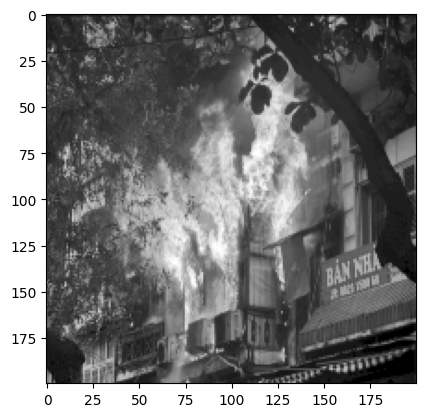

1/1 [==============================] - 1s 922ms/step
[1]
Có hỏa hoạn


In [31]:
choose_and_predict_fire()